In [1]:
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from langchain_groq import ChatGroq

## Reducers
from typing import Annotated, Dict, Any
from langgraph.graph.message import add_messages

from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [2]:
llm = ChatGroq(model="openai/gpt-oss-120b", temperature=0)

from Tools import find_available_doctors, get_doctor_schedule
tools=[find_available_doctors, get_doctor_schedule]
llm_tools = llm.bind_tools(tools)

In [3]:
class ClinicalWorkflowState(TypedDict):

    messages: Annotated[list, add_messages]
    triage: Dict[str, Any]

In [4]:
def triage_reasoning_agent(state: ClinicalWorkflowState):

    # Infer speciality from symptom and the find doctor based on the derieved speciality
    system_prompt = """
    You are a triage reasoning agent.

    Your tasks: Execute the following task sequentially
    - If doctor's name is provided in the user message, check if doctor's schedule matches with preferred date and time.
    - If schedule does NOT match, identify the doctor's specility and then select another doctor with the same specility matches best with preferred date and time.
    - If doctor name is NOT provided, but specility is provided in user message, then select one doctor matches best with preferred date and time.
    - If doctor name or specility is NOT provided in user message, Infer speciality based on the symptom. Then find a doctor based on the specility.
    - After receiving tool data, select only one doctor matches best based preferred date and time.
    - If schedule does NOT match, suggest the earliest availble doctor.
    - DO NOT call the same tool repeatedly. Call the tool ONLY ONCE.

    Available Speciality: 
        - General Medicine
        - Cardiology
        - Orthopedics
        - Gynecology
        - Pediatrics
        - Dermatology
        - Neurology
        - Psychiatry
        - ENT
        - Ophthalmology
        - Pulmonology
        - Gastroenterology
        - Endocrinology
        - Nephrology
    """

    llm_response = llm_tools.invoke(
        [{"role": "system", "content": system_prompt}] + state["messages"]  
    )

    return {"messages": llm_response}

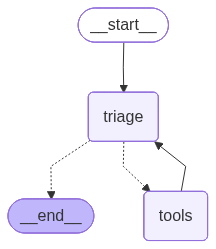

In [7]:
# Checkpointer
checkpointer = InMemorySaver()

graph = StateGraph(ClinicalWorkflowState)

# Register agents
graph.add_node("triage", triage_reasoning_agent)
graph.add_node("tools", ToolNode(tools))

graph.add_edge(START, "triage")
graph.add_conditional_edges(
    "triage",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
graph.add_edge("tools","triage")
graph.add_edge("triage", END)

graph_builder=graph.compile()
graph_builder

In [8]:
# NO doctor name or specility - Schedule Match
response = graph_builder.invoke({"messages": "I have High BP. Please suggest me a doctor who is available on Monday at 3 PM"})

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

I have High BP. Please suggest me a doctor who is available on Monday at 3 PM
================================== Ai Message ==================================
Tool Calls:
  find_available_doctors (fc_3099722a-0676-4310-b12c-d90747da2052)
 Call ID: fc_3099722a-0676-4310-b12c-d90747da2052
  Args:
    speciality: Cardiology
================================= Tool Message =================================
Name: find_available_doctors

[{"doctor_id": 8, "name": "Dr. Snehal Patil", "qualification": "MBBS, MD, DM", "available_from": "09:00", "available_to": "14:00", "available_days": "Mon,Thu"}, {"doctor_id": 6, "name": "Dr. Rajiv Mehra", "qualification": "MBBS, MD, DM", "available_from": "10:00", "available_to": "16:00", "available_days": "Mon,Wed,Fri"}, {"doctor_id": 10, "name": "Dr. Ritu Malhotra", "qualification": "MBBS, MD, DM", "available_from": "10:00", "available_to": "15:00", "available_days": "Tue,Sat"}

In [10]:
# NO doctor name or specility - Schedule NOT Match
response = graph_builder.invoke({"messages": "I have High BP. Please suggest me a doctor who is available on Sunday at 11 AM"})

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

I have High BP. Please suggest me a doctor who is available on Sunday at 11 AM
================================== Ai Message ==================================
Tool Calls:
  find_available_doctors (fc_96f4e69b-41b9-4192-bd8d-2fee4067a4ec)
 Call ID: fc_96f4e69b-41b9-4192-bd8d-2fee4067a4ec
  Args:
    speciality: Cardiology
================================= Tool Message =================================
Name: find_available_doctors

[{"doctor_id": 8, "name": "Dr. Snehal Patil", "qualification": "MBBS, MD, DM", "available_from": "09:00", "available_to": "14:00", "available_days": "Mon,Thu"}, {"doctor_id": 6, "name": "Dr. Rajiv Mehra", "qualification": "MBBS, MD, DM", "available_from": "10:00", "available_to": "16:00", "available_days": "Mon,Wed,Fri"}, {"doctor_id": 10, "name": "Dr. Ritu Malhotra", "qualification": "MBBS, MD, DM", "available_from": "10:00", "available_to": "15:00", "available_days": "Tue,Sat"

In [11]:
# Specility Mentioned - Schedule Match
response = graph_builder.invoke({"messages": "I have High BP. Please suggest me a General physician who is available on Monday at 1:30 PM"})

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

I have High BP. Please suggest me a General physician who is available on Monday at 1:30 PM
================================== Ai Message ==================================
Tool Calls:
  find_available_doctors (fc_fd606364-14ef-49c3-94d3-4cf5a2e240cb)
 Call ID: fc_fd606364-14ef-49c3-94d3-4cf5a2e240cb
  Args:
    speciality: General Medicine
================================= Tool Message =================================
Name: find_available_doctors

[{"doctor_id": 1, "name": "Dr. Amit Sharma", "qualification": "MBBS, MD", "available_from": "09:00", "available_to": "13:00", "available_days": "Mon,Tue,Wed,Thu,Fri"}, {"doctor_id": 4, "name": "Dr. Nitin Agarwal", "qualification": "MBBS, MD", "available_from": "09:00", "available_to": "13:00", "available_days": "Mon,Tue,Thu"}, {"doctor_id": 2, "name": "Dr. Sunita Verma", "qualification": "MBBS, MD", "available_from": "10:00", "available_to": "14:00", "availabl

In [12]:
# Specility Mentioned - Schedule NOT Match
response = graph_builder.invoke({"messages": "I have High BP. Please suggest me a General physician who is available on Monday at 3:30 PM"})

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

I have High BP. Please suggest me a General physician who is available on Monday at 3:30 PM
================================== Ai Message ==================================
Tool Calls:
  find_available_doctors (fc_0ec28bc6-a639-48a0-a543-04e104354f9a)
 Call ID: fc_0ec28bc6-a639-48a0-a543-04e104354f9a
  Args:
    speciality: General Medicine
================================= Tool Message =================================
Name: find_available_doctors

[{"doctor_id": 1, "name": "Dr. Amit Sharma", "qualification": "MBBS, MD", "available_from": "09:00", "available_to": "13:00", "available_days": "Mon,Tue,Wed,Thu,Fri"}, {"doctor_id": 4, "name": "Dr. Nitin Agarwal", "qualification": "MBBS, MD", "available_from": "09:00", "available_to": "13:00", "available_days": "Mon,Tue,Thu"}, {"doctor_id": 2, "name": "Dr. Sunita Verma", "qualification": "MBBS, MD", "available_from": "10:00", "available_to": "14:00", "availabl

In [13]:
# Doctor Mentioned - Schedule Match
response = graph_builder.invoke({"messages": "I have High BP. I want to see Dr. Sandeep Singh on Monday at 10 AM"})

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

I have High BP. I want to see Dr. Sandeep Singh on Monday at 10 AM
================================== Ai Message ==================================
Tool Calls:
  get_doctor_schedule (fc_8055440d-ec6f-4af8-a4a3-544aaf9707ec)
 Call ID: fc_8055440d-ec6f-4af8-a4a3-544aaf9707ec
  Args:
    name: Dr. Sandeep Singh
================================= Tool Message =================================
Name: get_doctor_schedule

[{"doctor_id": 11, "speciality": "Orthopedics", "name": "Dr. Sandeep Singh", "qualification": "MBBS, MS", "available_from": "10:00", "available_to": "16:00", "available_days": "Mon,Wed,Fri"}]
================================== Ai Message ==================================

Your appointment is confirmed with **Dr. Sandeep Singh** (Orthopedics) on **Monday at 10:00 AM**.


In [14]:
# Doctor Mentioned - Schedule NOT Match
response = graph_builder.invoke({"messages": "I have High BP. I want to see Dr. Sandeep Singh on Tuesday at 2:30 PM"})

for m in response['messages']:
    m.pretty_print()


================================ Human Message =================================

I have High BP. I want to see Dr. Sandeep Singh on Tuesday at 2:30 PM
================================== Ai Message ==================================
Tool Calls:
  get_doctor_schedule (fc_afe76e96-4ca2-452b-9ad6-47c3ecee899d)
 Call ID: fc_afe76e96-4ca2-452b-9ad6-47c3ecee899d
  Args:
    name: Dr. Sandeep Singh
================================= Tool Message =================================
Name: get_doctor_schedule

[{"doctor_id": 11, "speciality": "Orthopedics", "name": "Dr. Sandeep Singh", "qualification": "MBBS, MS", "available_from": "10:00", "available_to": "16:00", "available_days": "Mon,Wed,Fri"}]
================================== Ai Message ==================================
Tool Calls:
  find_available_doctors (fc_57930693-650f-49c1-bbe6-7c5b157ec57b)
 Call ID: fc_57930693-650f-49c1-bbe6-7c5b157ec57b
  Args:
    speciality: Orthopedics
================================= Tool Message ============